## Visual Insights in Manhattan: A Deep Learning Analysis of Rental Listings

- Participants - May Zisbrod (Individual project)
- Objectives - This project aims to uncover correlations between visual features of rental listings of studio and one-bedroom apartments and various listing attributes, such as price, neighbourhood, and amenities. Using StreetEasy dataset extracted using RapidAPI, which includes rental information, and building images from Google Maps API, the project will explore how visual elements might influence rental prices and appeal. The primary objectives are:
  1. Price Prediction from Visual Cues - Determine if image-based features can predict rental prices in Manhattan neighbourhoods
  2. Amenity Detection - Assess if visual characteristics correlate with specific amenities or property types
  3. Neighbourhood Style Analysis - Identify unique visual patterns in neighbourhoods and explore how aesthetics vary across regions

In [346]:
# Import necessary libraries
import os
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import numpy as np
from IPython.display import Image as DisplayImage, display
from PIL import Image as PILImage
from sklearn.metrics import mean_absolute_error, r2_score
from tqdm import tqdm

### Load the data

In [181]:
# Load the JSON data
data = pd.read_json("dataset/detailed_listings_with_images.json")

# Display the first few rows
print(data.head())

        id    listedAt  daysOnMarket availableFrom  price    borough  \
0  4593171  2024-11-19             0    2024-11-19   3300  manhattan   
1  4593131  2024-11-19             0    2025-01-01   2675  manhattan   
2  4593091  2024-11-19             0    2024-11-19   2300  manhattan   
3  4593038  2024-11-19             0    2025-01-23   3234  manhattan   
4  4592985  2024-11-19             0    2024-11-19   3950  manhattan   

         neighborhood  zipcode propertyType  sqft  ...   latitude  longitude  \
0           yorkville    10028       rental     0  ...  40.775383 -73.954449   
1        east-village    10009       rental     0  ...  40.726677 -73.983707   
2              harlem    10026       rental     0  ...  40.802202 -73.955522   
3  financial-district    10038       rental     0  ...  40.707500 -74.005898   
4         murray-hill    10016        condo     0  ...  40.745201 -73.971802   

                                           amenities  builtIn  \
0  [central_ac, dishw

In [183]:
# Summary statistics of numerical features
print(data.describe())

# Information about the dataset (columns, data types, etc.)
print(data.info())

                 id  daysOnMarket        price       zipcode         sqft  \
count  7.440000e+02    744.000000   744.000000    744.000000   744.000000   
mean   4.570684e+06     24.899194  2889.365591  10033.903226   118.196237   
std    3.338832e+04     32.245639   590.514567    101.342423   249.925602   
min    4.274708e+06      0.000000  1500.000000  10001.000000     0.000000   
25%    4.568097e+06      6.000000  2450.000000  10011.750000     0.000000   
50%    4.581204e+06     14.000000  2805.000000  10022.000000     0.000000   
75%    4.588232e+06     31.250000  3300.000000  10031.000000     0.000000   
max    4.593171e+06    331.000000  4000.000000  12345.000000  1200.000000   

         bedrooms   bathrooms    latitude   longitude      builtIn  
count  744.000000  744.000000  744.000000  744.000000   744.000000  
mean     0.588710    1.004032   40.768729  -73.968605  1840.641129  
std      0.492399    0.109985    0.041037    0.023084   404.248826  
min      0.000000    0.000000 

### Visualize Feature Distributions

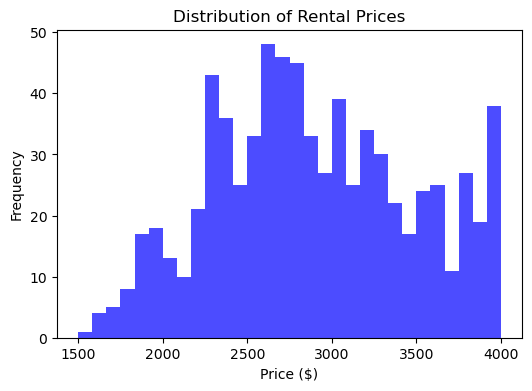

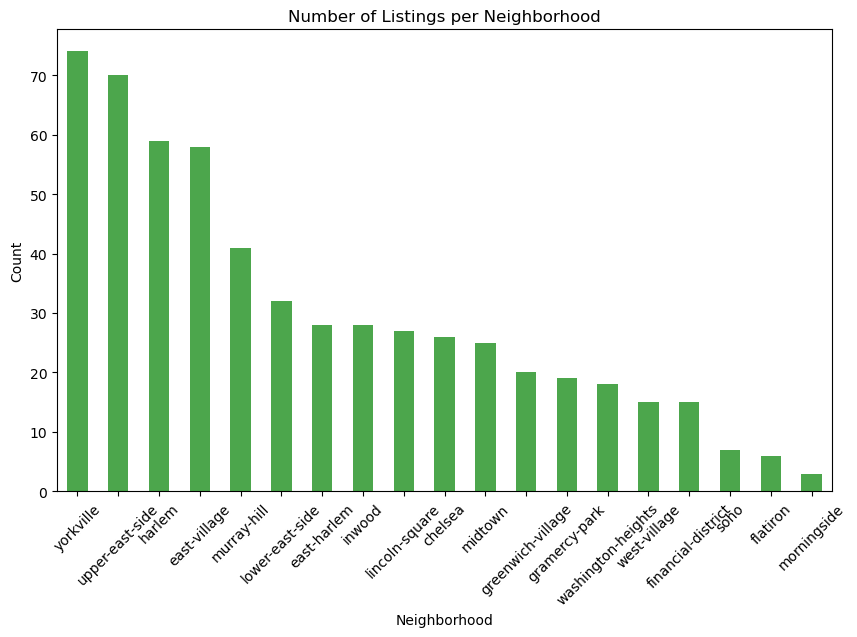

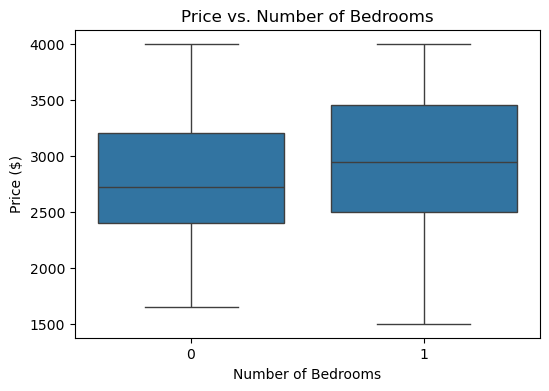

In [185]:
# Plot the distribution of rental prices
plt.figure(figsize=(6, 4))
plt.hist(data['price'], bins=30, color='blue', alpha=0.7)
plt.title("Distribution of Rental Prices")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.show()

# Count of listings per neighborhood
plt.figure(figsize=(10, 6))
data['neighborhood'].value_counts().plot(kind='bar', color='green', alpha=0.7)
plt.title("Number of Listings per Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Boxplot for price grouped by bedrooms
plt.figure(figsize=(6, 4))
sns.boxplot(x=data['bedrooms'], y=data['price'])
plt.title("Price vs. Number of Bedrooms")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Price ($)")
plt.show()

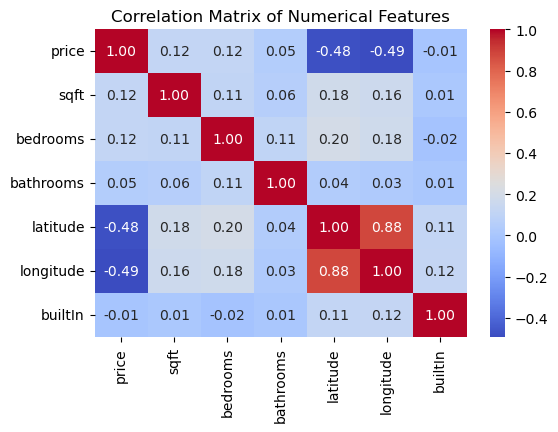

In [187]:
# Correlation analysis for numerical features 
# Select numerical columns for correlation
numerical_cols = ['price', 'sqft', 'bedrooms', 'bathrooms', 'latitude', 'longitude', 'builtIn']
correlation_matrix = data[numerical_cols].corr()

# Heatmap of correlations
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [189]:
# Display a few listings with images and details
sample_data = data.sample(2)

for _, row in sample_data.iterrows():
    print(f"ID: {row['id']}, Price: ${row['price']}, Neighborhood: {row['neighborhood']}")
    print(f"Description: {row['description']}\n")
    
    display(DisplayImage(url=row['image_url']))

ID: 4582353, Price: $2750, Neighborhood: yorkville
Description: Welcome to this inviting and spacious one-bedroom apartment! 
Separate kitchen. Ample closet space throughout the apartment provides plenty of storage for all your belongings, making it easy to stay organized.

Wooden floors throughout. Exposed brick walls bring a unique New York. 
Enjoy year-round comfort with installed AC.

Located in a vibrant neighborhood with easy access to local cafes, restaurants, and public transportation, this apartment is a perfect blend of style, function, and charm. Don’t miss out on making it yours!



ID: 4585015, Price: $2895, Neighborhood: lincoln-square
Description: PLEASE WATCH VIDEO … (Low Fee / No Pets).
- Queen Size Bedroom w/ Exposed Brick Walls
- Private Terrace w/ Open City Views
- South Exposure w/ Open Views
- Large Closets AND overhead storage
- Amazing Lincoln Square Location
- 1 Block to Trader Joes & 1,2,3 Subway.



### Data Preprocessing

In [348]:
# Dataset class for PyTorch
class RentalDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, f"{int(row['id'])}.jpg")
        
        # Debug: Check if the image file exists
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found for ID {row['id']} at {img_path}")
    
        # Load and process the image
        image = PILImage.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
    
        # Extract structured data
        structured_data = torch.tensor(
            row[[col for col in self.data.columns if col.startswith("feat_")]].values,
            dtype=torch.float
        )
        label = torch.tensor(row["price"], dtype=torch.float)
    
        return image, structured_data, label

In [350]:
# Prepare data
# Load and process structured data
data = pd.read_json("dataset/detailed_listings_with_images.json")
columns_to_use = ["id", "neighborhood", "sqft", "bedrooms", "bathrooms", "builtIn", "latitude", "longitude"]
data = data[columns_to_use + ["price"]]

# Encode categorical features
encoder = OneHotEncoder()
encoded_neighborhoods = encoder.fit_transform(data[["neighborhood"]]).toarray()

# Normalize numerical features
scaler = StandardScaler()
numerical_features = scaler.fit_transform(data[["sqft", "bedrooms", "bathrooms", "builtIn", "latitude", "longitude"]])

# Combine features
features = np.hstack([encoded_neighborhoods, numerical_features])
processed_data = pd.DataFrame(features, columns=[f"feat_{i}" for i in range(features.shape[1])])
processed_data["id"] = data["id"].astype(int)

# Calculate structured_input_size based on the number of feat_* columns
structured_input_size = len([col for col in processed_data.columns if col.startswith("feat_")])

scaler_price = MinMaxScaler()
processed_data["price"] = scaler_price.fit_transform(data[["price"]])

# Split dataset: training (70%), validation (15%), and testing (15%)
train_data, val_test_data = train_test_split(processed_data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)

# Image preprocessing
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomCrop(224, padding=20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets and loaders
train_dataset = RentalDataset(train_data, "dataset/images", transform=image_transforms)
test_dataset = RentalDataset(test_data, "dataset/images", transform=image_transforms)
val_dataset = RentalDataset(val_data, "dataset/images", transform=image_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

### Define the model

In [352]:
class PricePredictionModel(nn.Module):
    def __init__(self, structured_input_size):
        super(PricePredictionModel, self).__init__()
        # Pretrained CNN for image feature extraction
        self.cnn = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.cnn.fc = nn.Sequential(
            nn.Linear(2048, 512), # ResNet50 outputs 2048; reduce it to 512
            nn.ReLU()
        )

        # Fully connected layers for structured data
        self.structured_fc = nn.Sequential(
            nn.Linear(structured_input_size, 64), # Reduce dimensions for structured features
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Combined layers
        self.fc = nn.Sequential(
            nn.Linear(512 + 64, 128), # Adjust input size to match concatenation
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, structured_data):
        image_features = self.cnn(image)
        structured_features = self.structured_fc(structured_data)
        combined = torch.cat((image_features, structured_features), dim=1)
        return self.fc(combined)

### Training the Model

In [354]:
# Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PricePredictionModel(structured_input_size).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.MSELoss()

# Early stopping setup
patience = 5
min_val_loss = float('inf')
early_stop_counter = 0
best_model_weights = None

train_losses, val_losses = [], []

for epoch in range(20):
    model.train()
    running_loss = 0.0

    for images, structured_data, prices in tqdm(train_loader, desc=f"Epoch {epoch+1}/20"):
        images, structured_data, prices = images.to(device), structured_data.to(device), prices.to(device)

        # Forward pass
        outputs = model(images, structured_data)
        loss = criterion(outputs.flatten(), prices)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation loss
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, structured_data, prices in val_loader:
            images, structured_data, prices = images.to(device), structured_data.to(device), prices.to(device)
            outputs = model(images, structured_data)
            loss = criterion(outputs.flatten(), prices)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        early_stop_counter = 0
        best_model_weights = model.state_dict()
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Epoch {epoch+1}/20, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Load best model weights
if best_model_weights:
    model.load_state_dict(best_model_weights)

Epoch 1/20: 100%|█████████████████████████████████| 9/9 [01:28<00:00,  9.83s/it]


Epoch 1/20, Train Loss: 1193.5980, Validation Loss: 46596070129532928.0000


Epoch 2/20: 100%|█████████████████████████████████| 9/9 [01:32<00:00, 10.29s/it]


Epoch 2/20, Train Loss: 0.2247, Validation Loss: 5174568.2500


Epoch 3/20: 100%|█████████████████████████████████| 9/9 [01:32<00:00, 10.31s/it]


Epoch 3/20, Train Loss: 0.0989, Validation Loss: 1115.1690


Epoch 4/20: 100%|█████████████████████████████████| 9/9 [01:30<00:00, 10.05s/it]


Epoch 4/20, Train Loss: 0.0753, Validation Loss: 7.8836


Epoch 5/20: 100%|█████████████████████████████████| 9/9 [01:33<00:00, 10.35s/it]


Epoch 5/20, Train Loss: 0.0994, Validation Loss: 1.0167


Epoch 6/20: 100%|█████████████████████████████████| 9/9 [01:28<00:00,  9.84s/it]


Epoch 6/20, Train Loss: 0.1530, Validation Loss: 1.0097


Epoch 7/20: 100%|█████████████████████████████████| 9/9 [01:29<00:00,  9.96s/it]


Epoch 7/20, Train Loss: 0.0680, Validation Loss: 0.0562


Epoch 8/20: 100%|█████████████████████████████████| 9/9 [01:32<00:00, 10.25s/it]


Epoch 8/20, Train Loss: 0.0551, Validation Loss: 0.0831


Epoch 9/20: 100%|█████████████████████████████████| 9/9 [01:28<00:00,  9.78s/it]


Epoch 9/20, Train Loss: 0.0635, Validation Loss: 0.0581


Epoch 10/20: 100%|████████████████████████████████| 9/9 [01:35<00:00, 10.65s/it]


Epoch 10/20, Train Loss: 0.0538, Validation Loss: 0.0361


Epoch 11/20: 100%|████████████████████████████████| 9/9 [01:29<00:00,  9.98s/it]


Epoch 11/20, Train Loss: 0.0430, Validation Loss: 0.0400


Epoch 12/20: 100%|████████████████████████████████| 9/9 [01:33<00:00, 10.36s/it]


Epoch 12/20, Train Loss: 0.0395, Validation Loss: 0.0426


Epoch 13/20: 100%|████████████████████████████████| 9/9 [01:35<00:00, 10.64s/it]


Epoch 13/20, Train Loss: 0.0497, Validation Loss: 0.0465


Epoch 14/20: 100%|████████████████████████████████| 9/9 [01:37<00:00, 10.86s/it]


Epoch 14/20, Train Loss: 0.0388, Validation Loss: 0.0321


Epoch 15/20: 100%|████████████████████████████████| 9/9 [01:30<00:00, 10.08s/it]


Epoch 15/20, Train Loss: 0.0495, Validation Loss: 0.0731


Epoch 16/20: 100%|████████████████████████████████| 9/9 [01:29<00:00,  9.89s/it]


Epoch 16/20, Train Loss: 0.0716, Validation Loss: 0.0343


Epoch 17/20: 100%|████████████████████████████████| 9/9 [01:31<00:00, 10.14s/it]


Epoch 17/20, Train Loss: 0.0454, Validation Loss: 0.0444


Epoch 18/20: 100%|████████████████████████████████| 9/9 [01:32<00:00, 10.33s/it]


Epoch 18/20, Train Loss: 0.0387, Validation Loss: 0.0302


Epoch 19/20: 100%|████████████████████████████████| 9/9 [01:30<00:00, 10.09s/it]


Epoch 19/20, Train Loss: 0.0342, Validation Loss: 0.0333


Epoch 20/20: 100%|████████████████████████████████| 9/9 [01:35<00:00, 10.56s/it]


Epoch 20/20, Train Loss: 0.0314, Validation Loss: 0.0320


### Testing and Evaluation

Test Loss: 0.0357
Mean Absolute Error (MAE): 373.27
R² Score: 0.2521

Example Predictions:
Actual Price   Predicted Price
$2900.00        $2475.94        
$4000.00        $3133.63        
$3950.00        $3311.54        
$2900.00        $3045.89        
$3895.00        $2904.98        
$2500.00        $2705.57        
$2700.00        $2377.76        
$2860.00        $3252.66        
$2485.00        $2243.41        
$4000.00        $3462.40        
$3325.00        $2830.53        
$3800.00        $3589.79        
$3100.00        $3035.33        
$3250.00        $4945.25        
$2850.00        $2883.61        
$3495.00        $3054.69        
$3750.00        $2729.51        
$3650.00        $2933.42        
$3000.00        $3351.33        
$2300.00        $2153.63        
$3150.00        $3538.40        
$3000.00        $2915.75        
$2600.00        $2519.00        
$2295.00        $3055.29        
$1750.00        $1952.44        
$3495.00        $2557.44        
$3750.00        $275

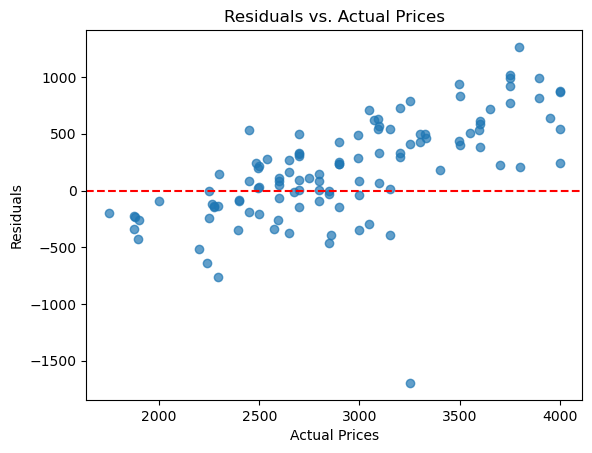

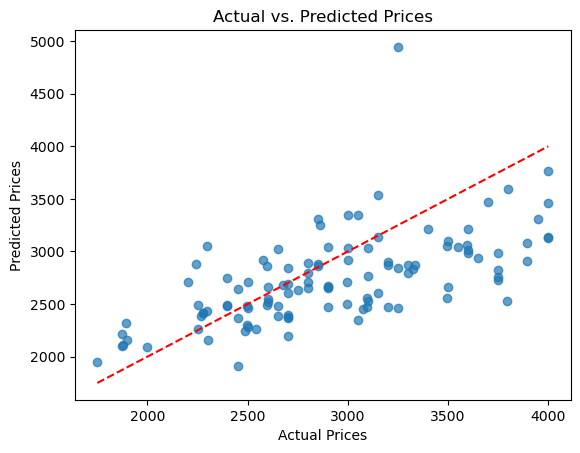

In [360]:
# Model evaluation
model.eval()
total_loss = 0.0
all_preds, all_actuals, examples = [], [], []

with torch.no_grad():
    for images, structured_data, prices in test_loader:
        images, structured_data, prices = images.to(device), structured_data.to(device), prices.to(device)
        
        # Model predictions
        outputs = model(images, structured_data)
        loss = criterion(outputs.flatten(), prices)
        total_loss += loss.item()
        
        # Collect predictions and actual prices
        all_preds.extend(outputs.flatten().cpu().numpy())
        all_actuals.extend(prices.cpu().numpy())
        
        # Store a few examples for visualization (limiting to 5 for brevity)
        if len(examples) < 5:
            examples.extend(list(zip(
                scaler_price.inverse_transform(prices.cpu().numpy().reshape(-1, 1)).flatten(),
                scaler_price.inverse_transform(outputs.flatten().cpu().numpy().reshape(-1, 1)).flatten()
            )))

# Rescale predictions and actual prices
all_preds_rescaled = scaler_price.inverse_transform(np.array(all_preds).reshape(-1, 1)).flatten()
all_actuals_rescaled = scaler_price.inverse_transform(np.array(all_actuals).reshape(-1, 1)).flatten()

# Metrics
mae = mean_absolute_error(all_actuals_rescaled, all_preds_rescaled)
r2 = r2_score(all_actuals_rescaled, all_preds_rescaled)

# Print metrics
print(f"Test Loss: {total_loss / len(test_loader):.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Display example predictions
print("\nExample Predictions:")
print(f"{'Actual Price':<15}{'Predicted Price':<15}")
for actual, predicted in examples:
    print(f"${actual:<15.2f}${predicted:<15.2f}")

# Residuals plot
residuals = all_actuals_rescaled - all_preds_rescaled
plt.scatter(all_actuals_rescaled, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Actual Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.show()

# Plot actual vs predicted prices
plt.scatter(all_actuals_rescaled, all_preds_rescaled, alpha=0.7)
plt.plot([all_actuals_rescaled.min(), all_actuals_rescaled.max()], 
         [all_actuals_rescaled.min(), all_actuals_rescaled.max()], 
         color='red', linestyle='--')  # Reference line
plt.title("Actual vs. Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.show()

Test Loss: 0.0473
Mean Absolute Error (MAE): 412.94
R² Score: -0.0092
Actual Price: $2900.00, Predicted Price: $2483.68


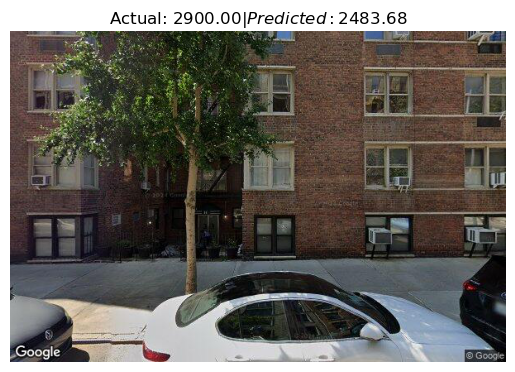

Actual Price: $4000.00, Predicted Price: $3138.26


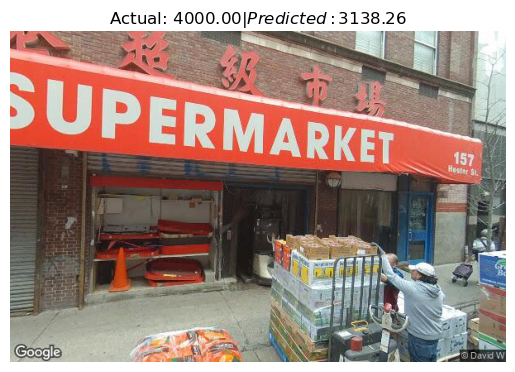

Actual Price: $3950.00, Predicted Price: $3312.24


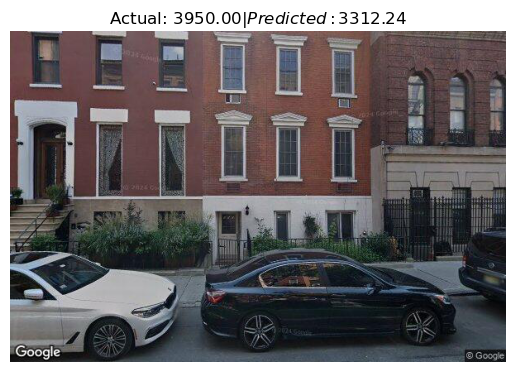

Actual Price: $2900.00, Predicted Price: $3035.86


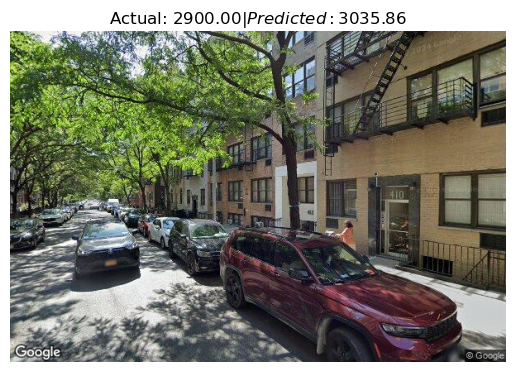

Actual Price: $3895.00, Predicted Price: $2913.43


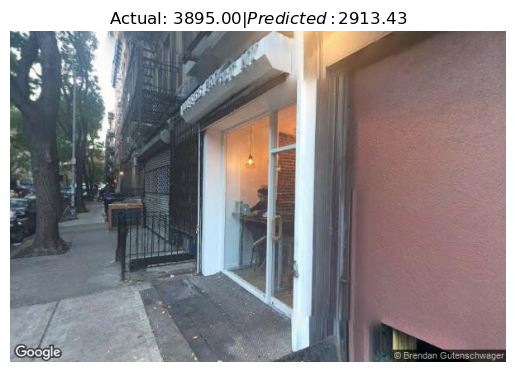

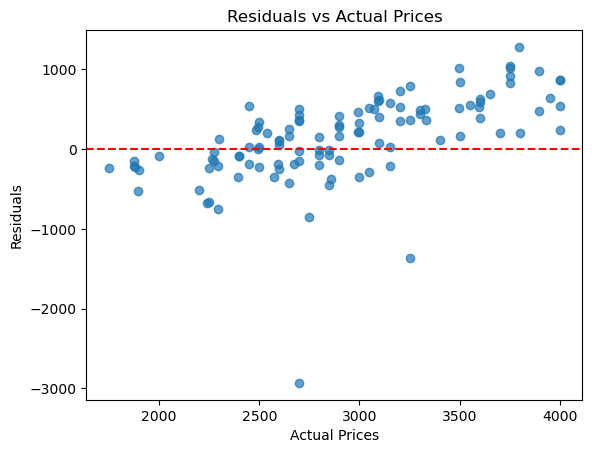

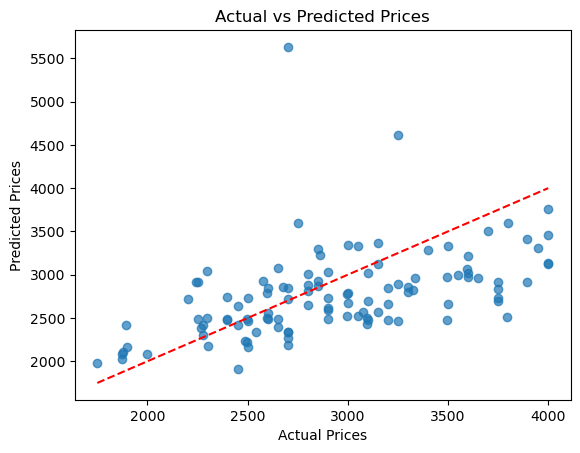

In [364]:
# Model evaluation
model.eval()
total_loss = 0.0
all_preds, all_actuals, examples = [], [], []

# Directory for test images
image_dir = "dataset/images"

with torch.no_grad():
    for images, structured_data, prices in test_loader:
        images, structured_data, prices = images.to(device), structured_data.to(device), prices.to(device)
        
        # Model predictions
        outputs = model(images, structured_data)
        loss = criterion(outputs.flatten(), prices)
        total_loss += loss.item()
        
        # Collect predictions and actual prices
        all_preds.extend(outputs.flatten().cpu().numpy())
        all_actuals.extend(prices.cpu().numpy())
        
        # Store examples with images (limit to 5 for brevity)
        if len(examples) < 5:
            for i in range(images.size(0)):
                if len(examples) < 5:
                    image_path = os.path.join(image_dir, f"{int(test_data.iloc[len(examples)]['id'])}.jpg")
                    examples.append({
                        "actual": scaler_price.inverse_transform(prices.cpu().numpy()[i].reshape(-1, 1)).flatten()[0],
                        "predicted": scaler_price.inverse_transform(outputs.flatten().cpu().numpy()[i].reshape(-1, 1)).flatten()[0],
                        "image_path": image_path
                    })

# Rescale predictions and actual prices
all_preds_rescaled = scaler_price.inverse_transform(np.array(all_preds).reshape(-1, 1)).flatten()
all_actuals_rescaled = scaler_price.inverse_transform(np.array(all_actuals).reshape(-1, 1)).flatten()

# Metrics
mae = mean_absolute_error(all_actuals_rescaled, all_preds_rescaled)
r2 = r2_score(all_actuals_rescaled, all_preds_rescaled)

# Print metrics
print(f"Test Loss: {total_loss / len(test_loader):.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Display example predictions with images
for example in examples:
    actual = example["actual"]
    predicted = example["predicted"]
    image_path = example["image_path"]
    print(f"Actual Price: ${actual:.2f}, Predicted Price: ${predicted:.2f}")
    
    # Display image
    try:
        img = PILImage.open(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Actual: ${actual:.2f} | Predicted: ${predicted:.2f}")
        plt.show()
    except FileNotFoundError:
        print(f"Image not found: {image_path}")

# Residuals plot
residuals = all_actuals_rescaled - all_preds_rescaled
plt.scatter(all_actuals_rescaled, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Actual Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.show()

# Plot actual vs predicted prices
plt.scatter(all_actuals_rescaled, all_preds_rescaled, alpha=0.7)
plt.plot([all_actuals_rescaled.min(), all_actuals_rescaled.max()], 
         [all_actuals_rescaled.min(), all_actuals_rescaled.max()], 
         color='red', linestyle='--')  # Reference line
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.show()
